# Sentimental Analysis of Movie Reviews

### by Karma Tsering
My goal is to predict sentiment of each movie reviews.

### Motivation of this project
There are too many movies and too many people with opnion on them. Its doubtful that any one would want to read these reviews, certly not companies that need to 

### Data Source
This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. 

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). 

In the entire collection, no more than 30 reviews are allowed for any given movie because reviews for the same movie tend to have correlated ratings. In the labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets.

In [1]:
import numpy as np
import pandas as pd
from os import listdir
%matplotlib inline

import spacy
nlp = spacy.load('en')

import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from os.path import isfile, join

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

In [2]:
#saves list of files names to loop though
neg_train_file_names = [f for f in listdir('aclImdb\\train\\neg') if isfile(join('aclImdb\\train\\neg', f))]
pos_train_file_names = [f for f in listdir('aclImdb\\train\\pos') if isfile(join('aclImdb\\train\\pos', f))]

In [8]:
#The reviews are saved in each individual files, so I looped through each file and saved the content of the files as 
#and assigned a sentement based on which folder the file was in (neg = 0/ pos = 1).
review_df1 = []
review_df2 = []

for file in neg_train_file_names:
    file1_open = open("aclImdb\\train\\neg\\{}".format(file), encoding="utf8")
    file1_content = file1_open.read()
    review_df1.append([file1_content, 0])
    
for file in pos_train_file_names:
    file1_open = open("aclImdb\\train\\pos\\{}".format(file), encoding="utf8")
    file1_content = file1_open.read()
    review_df2.append([file1_content, 1])

In [9]:
#Put them in DataFrame format
review_df1 = pd.DataFrame(review_df1)
review_df2 = pd.DataFrame(review_df2)

In [10]:
#put all the above dataframe in one dataframe
review_df = pd.concat([review_df1, review_df2]).sample(frac=1).reset_index(drop=True)
review_df.columns = ['Review', 'Rating']
print(review_df.shape)
review_df.head(10)

(25000, 2)


,Review,Rating
0,This was quite possibly the worst movie I have...,0
1,I guess this would be a great movie for a true...,0
2,"""They All Laughed"" is one of those little movi...",1
3,"I'm not a huge Freddy Krueger fan,but that doe...",0
4,To me this was Colin Farrells best movie evr! ...,1
5,Several features of this film immediately date...,1
6,"In 2004, I liked it. Then it became very stupi...",0
7,I saw this important intense film tonight. Its...,1
8,What a poor image of Professional Police Offic...,0
9,Pearl S.Buck was a brilliant author that was a...,1


### Data Frame created above

# text file for making BOW
Put all the reviews in one string in perperation for extrating key words to be used as feature later on for creating vector.

### Pick 2000 words and make BOW

In [11]:
#I cleanded the text as much as possible so to reduce load for nlp processing and to increase the number of vocas for feature
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
allwords = " "
list_of_review = []
Review = []
pattern = "[-*:&$%'\\?\"/<>()\d]"
pattern2 = r"\bbr\b"
pattern3 = r'\bA\b'
pattern4 = r'--'
#pattern5 = '.+;$'

for review in review_df['Review'][0:15000]:
    #cleaning up each review text by removing above patters
    mov_review = re.sub(pattern, "", review)
    mov_review = re.sub(pattern2, "", mov_review)
    mov_review = re.sub(pattern3, "", mov_review)
    mov_review = re.sub(pattern4, "", mov_review)
    #mov_review = re.sub(pattern5, "", mov_review)
    mov_review = mov_review.split()
    mov_review = [x for x in mov_review
                if not x == ' '
                and not x == 'movie'
                and not x == '-PRON-'
                and not x == 'film'
                and not x == '\x96']

    Onefull_review = ''
    for review_words in mov_review:
        Onefull_review = Onefull_review + ' ' + review_words
    list_of_review.append(Onefull_review)

list_of_review = pd.DataFrame(list_of_review)
list_of_review.columns = ['Review']
list_of_review['Rating'] = review_df['Rating'][0:15000]
list_of_review.to_csv("list_of_review.csv")

In [2]:
list_of_review = pd.read_csv('list_of_review.csv', encoding="ISO-8859-1").drop('Unnamed: 0', 1)
print(list_of_review.shape)
list_of_review.head(10)

(15000, 2)


,Review,Rating
0,This was quite possibly the worst I have ever...,0
1,I guess this would be a great for a true beli...,0
2,They All Laughed is one of those little movie...,1
3,"Im not a huge Freddy Krueger fan,but that doe...",0
4,To me this was Colin Farrells best evr! He in...,1
5,Several features of this immediately date it....,1
6,"In , I liked it. Then it became very stupid. ...",0
7,I saw this important intense tonight. Its Ric...,1
8,What a poor image of Professional Police Offi...,0
9,Pearl S.Buck was a brilliant author that was ...,1


# vectorization of DF using Inverse Document Frequency and Term-frequency weights (tfidf) and create a vector space model.

<br>
<br>

$$\textrm{Term frequency}= TF(t,d) = \frac{\textrm{number of times term(t) appears in document(d)}}{\textrm{total number ofterms in document(d)}}$$
<br>
<br>

$$\textrm{Inverse Documment Frequency}= IDF(t,D) = \frac{\textrm{total number of documents(D)}}{\textrm{number of documents with the term(t) in it}}$$

<br>
<br>

$$TFIDF(t,d,D) = TF(t,d)\cdot IDF(t,D)$$

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorize only 5,000 rows of the review because my computer can't handle more
#split the orighal df into train and test sets for comparison leater
X_train, X_test, y_train, y_test = train_test_split(list_of_review['Review'], list_of_review['Rating'], test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             #lowercase=True, #convert everything to lower case
                             use_idf=True,#inverse document frequencies
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies. Prevents divide-by-zero errors
                            )


#Applying the vectorizer to 5,000 row
list_of_review_tfidf=vectorizer.fit_transform(list_of_review['Review'])
print("Number of features: %d" % list_of_review_tfidf.get_shape()[1])

#splitting into training and test sets of thos vetorized data
X_train_tfidf, X_test_tfidf= train_test_split(list_of_review_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()


Number of features: 38735


##### For graphing purpose

In [4]:
#singular Value Decomposition (SVD), reduce the feature space from 23051 to 10000.
#this takes long time to run
svd= TruncatedSVD(3)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 0.7281362020188361


# K-Mean
##### 2 clusters

In [5]:
from sklearn.cluster import KMeans
KMean = KMeans(n_clusters=2, random_state=42, n_jobs=-1)
KMean.fit(X_train_tfidf)

y_KMean2 = KMean.predict(X_train_tfidf)


# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_KMean2, y_train))

Comparing k-means clusters against the data:
Rating     0     1
row_0             
0       2351  3610
1       2180   859


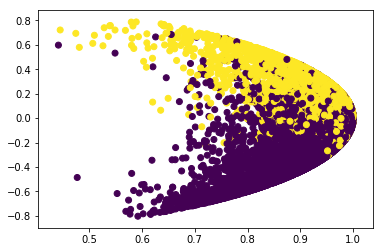

In [6]:
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_KMean2)
plt.show()

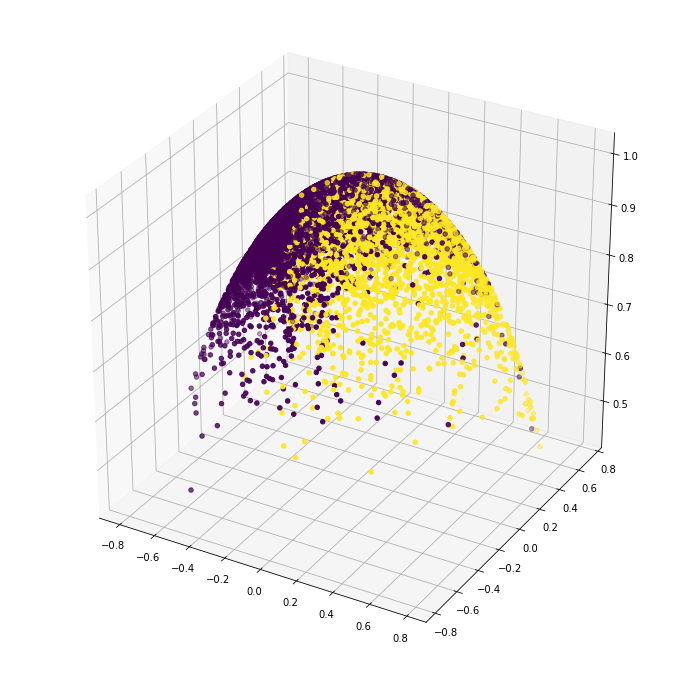

In [37]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_lsa[:, 1], X_train_lsa[:, 2], X_train_lsa[:, 0], zdir='z', c=y_KMean2)

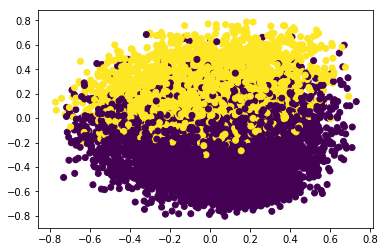

In [42]:
# Plot the solution.
plt.scatter(X_train_lsa[:, 2], X_train_lsa[:, 1], c=y_KMean2)
plt.show()

##### 3 clulster

In [8]:
from sklearn.cluster import KMeans
KMean = KMeans(n_clusters=3, random_state=42, n_jobs=-1)
KMean.fit(X_train_tfidf)

y_KMean3 = KMean.predict(X_train_tfidf)


# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_KMean3, y_train))

Comparing k-means clusters against the data:
Rating     0     1
row_0             
0       2035  3185
1       1325    69
2       1171  1215


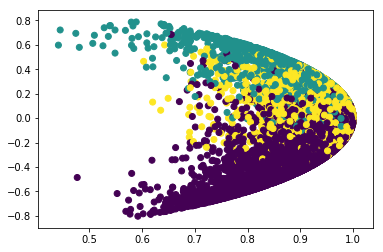

In [9]:
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_KMean3)
plt.show()

##### 4 clulster

In [10]:
from sklearn.cluster import KMeans
KMean = KMeans(n_clusters=4, random_state=42)
KMean.fit(X_train_tfidf)

y_KMean4 = KMean.predict(X_train_tfidf)


# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_KMean4, y_train))

Comparing k-means clusters against the data:
Rating     0     1
row_0             
0        142   284
1       1865  2780
2       1401  1330
3       1123    75


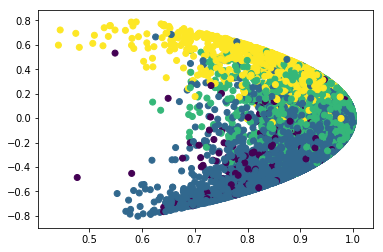

In [11]:
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_KMean4)
plt.show()

##### 2 clusters

In [12]:
from sklearn.cluster import MiniBatchKMeans
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_train_tfidf)

# Add the new predicted cluster memberships to the data frame.
predict_mini2 = minibatchkmeans.predict(X_train_tfidf)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(predict_mini2, y_train))

Comparing k-means clusters against the data:
Rating     0     1
row_0             
0       2759  1158
1       1772  3311


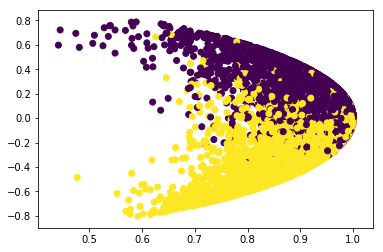

In [13]:
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=predict_mini2)
plt.show()

##### 3 clusters

In [15]:
from sklearn.cluster import MiniBatchKMeans
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=3,
    batch_size=200)
minibatchkmeans.fit(X_train_tfidf)

# Add the new predicted cluster memberships to the data frame.
predict_mini3 = minibatchkmeans.predict(X_train_tfidf)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(predict_mini3, y_train))

Comparing k-means clusters against the data:
Rating     0     1
row_0             
0        458   988
1       2543   996
2       1530  2485


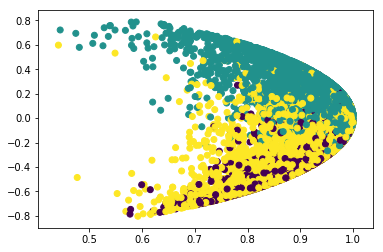

In [16]:
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=predict_mini3)
plt.show()

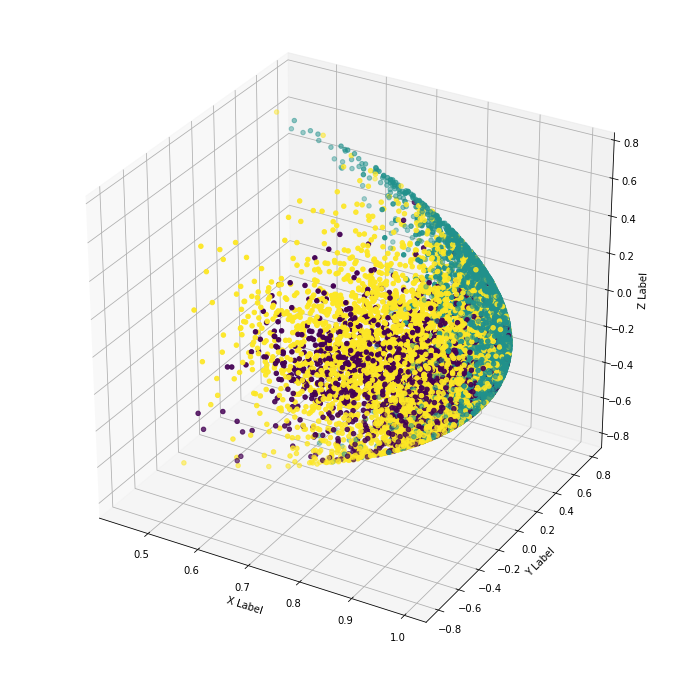

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], X_train_lsa[:, 2], c=predict_mini3, zdir='z')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

##### 4 clusters

In [18]:
from sklearn.cluster import MiniBatchKMeans
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=4,
    batch_size=200)
minibatchkmeans.fit(X_train_tfidf)

# Add the new predicted cluster memberships to the data frame.
predict_mini4 = minibatchkmeans.predict(X_train_tfidf)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(predict_mini4, y_train))

Comparing k-means clusters against the data:
Rating     0     1
row_0             
0        929   213
1       2297  3260
2       1173   718
3        132   278


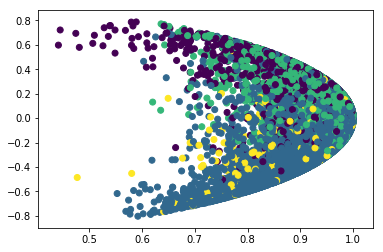

In [19]:
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=predict_mini4)
plt.show()

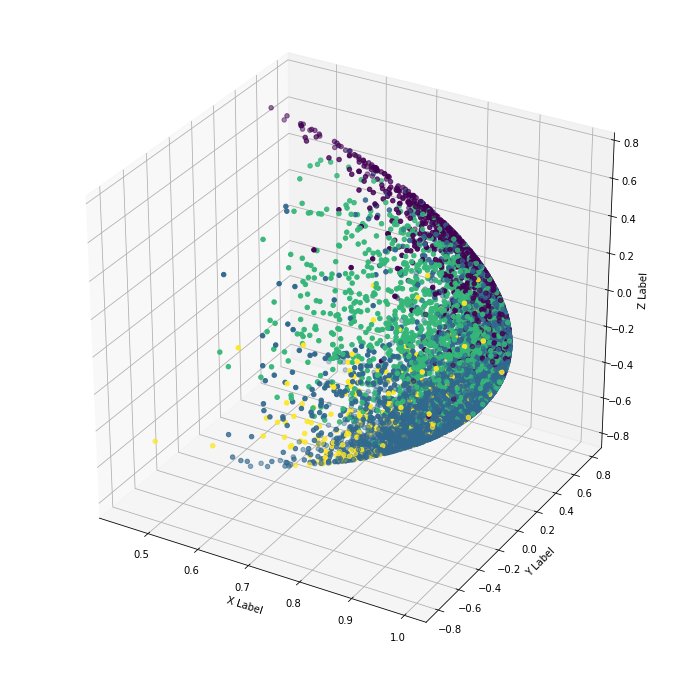

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], X_train_lsa[:, 2], c=predict_mini4, zdir='y')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


This predicta there to be only one cluster. If I reduce the bandwith, I get an error of no point being within the range of any seed.
# SpectralClustering

C:\Users\ktser\Anaconda3\lib\site-packages\scipy\sparse\csgraph\_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


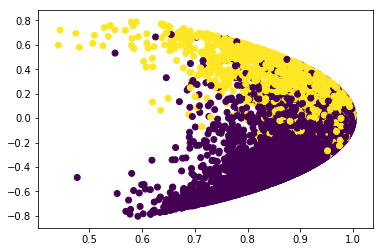

Comparing the assigned categories to the ones in the data:
col_0      0     1
Rating            
0       2467  2064
1       3719   750


In [43]:
from sklearn.cluster import SpectralClustering

# Declare and fit the model.
sc = SpectralClustering(n_clusters=2)
sc.fit(X_train_tfidf)

#Predicted clusters.
pred_spectral2 =sc.fit_predict(X_train_tfidf)

#Graph results.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=pred_spectral2)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,pred_spectral2))

# MeanShift

In [105]:
X_train_tfidf = X_train_tfidf.todense()

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_tfidf, quantile=0.2, n_samples=1000,  n_jobs=-1)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_tfidf)

y_MShift = ms.predict(X_train_tfidf)
# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_MShift,  y_train))

# AffinityPropagation

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train_tfidf)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

# BoW with Logistic Regression

In [107]:
#First trying some classicication models starting with logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train_tfidf, y_KMean)

print(X_train_tfidf.shape, y_train.shape)
print('Training set score:', lr.score(X_train_tfidf, y_KMean))

y_pred = lr.predict(X_train_tfidf)
pd.crosstab(y_KMean, y_pred)

(9000, 38735) (9000,)
Training set score: 0.9686666666666667


col_0,0,1,2
row_0,,,
0,5220,0,0
1,109,1257,28
2,145,0,2241


# GradientBoosting

In [98]:
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train_tfidf, predict_mini)

y_pred = clf.predict(X_train_tfidf)


# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, predict_mini))

Comparing k-means clusters against the data:
col_0     0     1
row_0            
0      3082   138
1       463  5317


In [99]:
print('Training set score:', clf.score(X_train_tfidf, predict_mini))

Training set score: 0.9332222222222222


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], X_train_lsa[:, 2], c=y_KMean, zdir='x')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
